In [9]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy import stats
plt.style.use('cashaback_dark')

### No Agent Version

This selects the optimal time based solely off distributions, it's as if you can't see the agent, but if you go after them on the reaction time you win 

In [21]:
# Not including probability of agent, only if probability of reacting and making it drops below 0.5
reaction_movement_time = 300
reaction_movement_uncertainty = 40 # We have some uncertainty about making it 
movement_uncertainty = 20
movement_time = 125

timing_uncertainty = 75 # Ok so as we iterate thru every time step, we have some distribution around the actual time

time_steps = np.arange(0,1510,10)
trials =100
uncertain_decision_time = np.zeros((trials))
actual_decision_time = np.zeros((trials))
prob_of_reacting_and_making = np.zeros((trials, len(time_steps)))
prob_of_making = np.zeros((trials, len(time_steps)))
for i in range(trials):
    j=-1
    for time in time_steps:
        j+=1
        t = time #stats.norm.rvs(time_steps[j],timing_uncertainty)
        prob_of_reacting_and_making[i,j] = stats.norm.cdf(1500-t,reaction_movement_time,reaction_movement_uncertainty)
        prob_of_making[i,j] = stats.norm.cdf(1500-t,movement_time,movement_uncertainty)
        if prob_of_reacting_and_making[i,j]<=0.5:
            #print(prob_of_reacting_and_making[i,j],prob_of_making[i,j])
            uncertain_decision_time[i] = t
            actual_decision_time[i] = time
            break

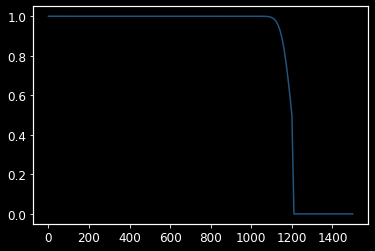

In [22]:
fig,ax = plt.subplots()
ax.plot(time_steps,prob_of_reacting_and_making[0,:])

HOW DO I MAKE THIS MORE ADAPTIVE???
If the agent goes at 1200-150, I will likely be able to use this
- I think I need a term that has the possibility that I could use it (that's different than prob_of_using_agent)


In [112]:
# Now throw in the prior of prob_of_using_agent
agent_mean_decision_time, agent_sd_decision_time = 1200,20000
prob_of_using_agent = stats.norm.cdf(1500,agent_mean_decision_time + reaction_movement_time, agent_sd_decision_time)
reaction_time = 300
reaction_movement_time = 390
reaction_movement_uncertainty = 40 # We have some uncertainty about making it 
movement_uncertainty = 20
movement_time = 125

timing_uncertainty = 75 # Ok so as we iterate thru every time step, we have some distribution around the actual time

time_steps = np.arange(0,1510,10)
trials =100
uncertain_decision_time = np.zeros((trials))
actual_decision_time = np.zeros((trials))
expected_reward_gamble = np.zeros((trials,len(time_steps)))
expected_reward_react = np.zeros((trials,len(time_steps)))
prob_of_reacting_and_making = np.zeros((trials,len(time_steps)))
react_reward = 1
gamble_reward = 0.5
indecision_reward = 0
for i in range(trials):
    j=-1
    flag = True
    for t in time_steps:
        j+=1
        measured_time = stats.norm.rvs(t,timing_uncertainty)
        prob_of_reacting_and_making[i,j] = stats.norm.cdf(1500-t,reaction_movement_time,reaction_movement_uncertainty)
        expected_reward_react[i,j] = prob_of_reacting_and_making[i,j]*prob_of_using_agent*react_reward + ((1-prob_of_reacting_and_making[i,j])*(1-prob_of_using_agent)*indecision_reward)
        
        prob_of_making = stats.norm.cdf(1500-t,movement_time,movement_uncertainty)
        expected_reward_gamble[i,j] = prob_of_making*gamble_reward +(1-prob_of_making)*indecision_reward
        
        if expected_reward_react[i,j]<=expected_reward_gamble[i,j] and flag:
            uncertain_decision_time[i] = t #+ reaction_time
            actual_decision_time[i] = t #+ reaction_time # Adding reaction_time because our measure of decision time is when they leave the circle, so that's after they've gone through reaction time
            flag = False

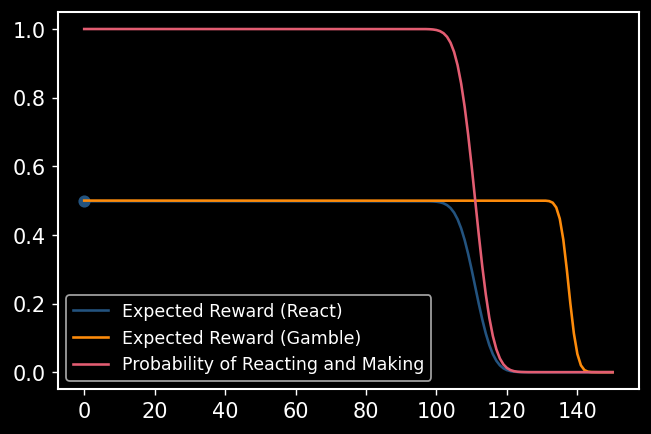

In [113]:
for i in range(1):
    fig, ax = plt.subplots(dpi=125)
    ax.plot(expected_reward_react[i,:], label = 'Expected Reward (React)')
    ax.scatter(actual_decision_time[i]/10,expected_reward_react[i,int(actual_decision_time[i]/10)])
    ax.plot(expected_reward_gamble[i,:], label = 'Expected Reward (Gamble)')
    ax.plot(prob_of_reacting_and_making[i,:], label = 'Probability of Reacting and Making')
    ax.set_ylim(-0.05,1.05)
    ax.legend(fontsize = 10, loc = 'lower left')
    plt.show()

Combing prob of using agent and porb of reacting and making into just the probability of reacting and making... instead of reaction_movement_time like above, now I have the mean agent move time + react_move_time 

In [110]:
# Now throw in the prior of prob_of_using_agent
agent_mean_decision_time, agent_sd_decision_time = 1000,1000
prob_of_using_agent = stats.norm.cdf(1500,agent_mean_decision_time + reaction_movement_time, agent_sd_decision_time)
reaction_time = 300
reaction_movement_time = 390
reaction_movement_uncertainty = 40 # We have some uncertainty about making it 
movement_uncertainty = 20
movement_time = 125

timing_uncertainty = 75 # Ok so as we iterate thru every time step, we have some distribution around the actual time

time_steps = np.arange(0,1510,10)
trials = 100
uncertain_decision_time = np.zeros((trials))
actual_decision_time = np.zeros((trials))
expected_reward_gamble = np.zeros((trials,len(time_steps)))
expected_reward_react = np.zeros((trials,len(time_steps)))
prob_of_reacting_and_making = np.zeros((trials,len(time_steps)))
react_reward = 1
gamble_reward = 0.5
indecision_reward = 0
for i in range(trials):
    j=-1
    flag = True
    for t in time_steps:
        j+=1
        measured_time = stats.norm.rvs(t,timing_uncertainty)
        # THIS TERM WILL NOW INCLUDE AGENT MOVEMENT TIME AS THE MEAN
        prob_of_reacting_and_making[i,j] = stats.norm.cdf(1500-t, agent_mean_decision_time + reaction_movement_time, reaction_movement_uncertainty + agent_sd_decision_time)
        expected_reward_react[i,j] = prob_of_reacting_and_making[i,j]*react_reward + ((1-prob_of_reacting_and_making[i,j])*(1-prob_of_using_agent)*indecision_reward)
        
        prob_of_making = stats.norm.cdf(1500-t,movement_time,movement_uncertainty)
        expected_reward_gamble[i,j] = prob_of_making*gamble_reward + (1-prob_of_making)*indecision_reward
        
        if expected_reward_react[i,j]<=expected_reward_gamble[i,j] and flag:
            uncertain_decision_time[i] = t #+ reaction_time
            actual_decision_time[i] = t #+ reaction_time # Adding reaction_time because our measure of decision time is when they leave the circle, so that's after they've gone through reaction time
            flag = False

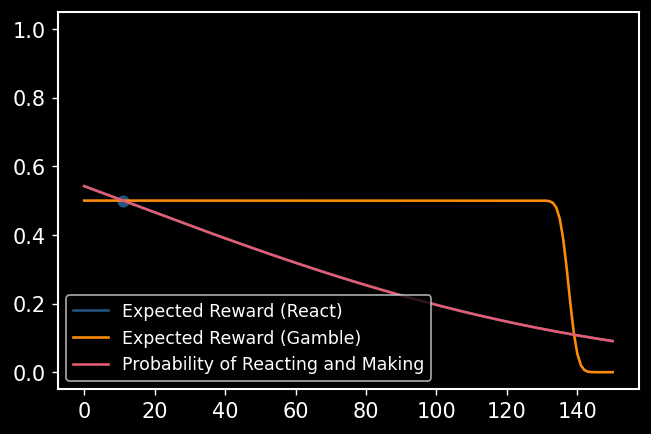

In [111]:
for i in range(1):
    fig, ax = plt.subplots(dpi=125)
    ax.plot(expected_reward_react[i,:], label = 'Expected Reward (React)')
    ax.scatter(actual_decision_time[i]/10,expected_reward_react[i,int(actual_decision_time[i]/10)])
    ax.plot(expected_reward_gamble[i,:], label = 'Expected Reward (Gamble)')
    ax.plot(prob_of_reacting_and_making[i,:], label = 'Probability of Reacting and Making')
    ax.set_ylim(-0.05,1.05)
    ax.legend(fontsize = 10, loc = 'lower left')
    plt.show()

### Plot expected reward over time

This plots expected reward given the agent movement time

In [5]:
expected_reward = 

SyntaxError: invalid syntax (1218037.py, line 1)